# IJF Web Scraper - Technical Test - Nova Scotia

Michael Wing-Cheung Wong

# Module Calls

In [1]:
############### PYTHON 3



#Module Imports
import os
import platform
import matplotlib
import re
import json
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# import selenium
import bs4

# from selenium import webdriver
# from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup

%matplotlib inline


print("Python ver. "+platform.python_version())
print("numpy ver. "+np.__version__)
print("pandas ver. "+pd.__version__)
print("seaborn ver. "+sns.__version__)
print("matplotlib ver. "+matplotlib.__version__)
# print("selenium ver. "+selenium.__version__)
print("bs4 ver. "+bs4.__version__)

pd.set_option('display.max_colwidth', None)

Python ver. 3.8.3
numpy ver. 1.21.0
pandas ver. 1.3.0
seaborn ver. 0.11.1
matplotlib ver. 3.4.2
bs4 ver. 4.9.3


# Scraper and Data Read-in

In [5]:
# Download the Great Pacific Garbage Patch wikipedia page and all edits

def get_pages(fileout, page, verbose):
    """
    cURL function to download a page and all edits in batches of 1000 revisions, converting them to dictionaries and saving them
    as JSON files per batch

    Parameters
    ----------
    fileout : str
        Path and filename string of the xml file to be created
    page : str
        Name of the wikipedia page to be downloaded
    verbose : bool
        Whether to display debugging data

    Returns
    -------
    df : dataframe object
        The final dataframe object for the page
    """
    
    if os.path.exists(fileout+".csv"):
        # Check if a csv file with that filename already exists, ask user for confirmation of overwrite
        while True:
            skip = input('''A data CSV file already exists with that name, 
do you wish to download all the data again, select no to load the existing file? (Y/N)''')
            if skip.lower().strip() == "n":
                return pd.read_csv(fileout+".csv")
            elif skip.lower().strip() == "y":
                break
            else:
                print("That's not a valid response. Please try again.")
    
    offset, i = 0, 0 
    batch_list = []
    while True:
        
        # Loop through queries until no revision remains (i.e. until most recent revision)
        
        curl_query = '''
        curl -d "&pages={}&action=submit&offset={}" https://en.wikipedia.org/w/index.php?title=Special:Export -o "{}"
        '''.format(page,offset,fileout+"_"+str(i)+".xml")

        print("\nCurrently querying:",curl_query)
        os.system(curl_query)
        print("Exported to",fileout+"_"+str(i)+".xml")

        filein = open(fileout+"_"+str(i)+".xml",encoding="utf-8")
        print("\nBeginning soup on file",fileout+"_"+str(i)+".xml")
        soup = bs4.BeautifulSoup(filein.read())#, "lxml")
        print("Done soup")

        print("\nCleaning data ...")
        revisions = soup.find_all("revision")
        
        # If no revision tag is found, that means that there are no more revisions,
        # therefore end the loop and return the final dataframe
        if not revisions:
            break

        # Output a test revision page
        if verbose == True:
            print("\nAn XML revision page")
            print(revisions[0])

        # For each revision, get a dictionary of the children tags and their respective values
        # and append to a list of all revisions
        revision_list = []
        for revision in revisions:
            children = revision.findChildren(recursive=False)
            children_dict = {}
            for child in children:
                children_dict[child.name] = child.getText()
            revision_list.append(children_dict) 

        revision_df = pd.DataFrame(revision_list)
        batch_list.append(revision_df)

        # Get the date and time of the final revision in the batch to set as the offset for the next batch
        offset = datetime.datetime.strptime(revision_df["timestamp"].iloc[-1],"%Y-%m-%dT%H:%M:%SZ")
        if verbose == True:
            print("\nA dataframe of all revisions in the batch")
            display(revision_df.tail())
            print("\nThe timestamp of the final revision in the batch")
            print(offset)

        # Sleep to allow wikipedia to get some well-deserved rest
        print("Data cleaned")
        time.sleep(10)
        i += 1
            
    print("\nDownload completed")
    
    # Concatenate all of the dataframes
    wikipedia_df = pd.concat(batch_list, sort=True)
    
    # Save all data to a csv file for future reference
    wikipedia_df.to_csv(fileout+".csv")
    print("Dataframe saved to",fileout+".csv")
            
    return wikipedia_df.reset_index()

NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"[name="q"]"}
  (Session info: headless chrome=91.0.4472.114)


In [ ]:
# For acquiring main page data
# fileout = "great_barrier_reef_wikipedia"
# wikipedia_df = get_wiki_edits(fileout="data/"+fileout,page="Great_Barrier_Reef",verbose=False)

# For acquiring subpage data
fileout = "great_barrier_reef_env_threats_wikipedia"
wikipedia_df = get_wiki_edits(fileout="data/"+fileout,page="Environmental_threats_to_the_Great_Barrier_Reef",verbose=False)

# Nova Scotia Lobbying Data Cleaning and Analysis

For this project, I am interested in the relationship between science and Wikipedia, in this case via the proxy of citations/references to scientific journal articles and books and governmental reports of the wikipedia page over time

In [228]:
def reference_regex(row):
    """
    Uses regex to replace reference tags possessing ids (ex. <ref name = 1975review>) with no-id reference tags (i.e. <ref>)
    then gets the information in-between the opening (<ref>) and closing (</ref>) reference tags.
    This information is then moved into a dictionary along with the character position of the reference string.
    
    Parameters
    ----------
    row : pd.Series
        A pandas series

    Returns
    -------
    row : pd.Series
        A pandas series
    """
    
    try:
        positions = []
        row["text"] = re.sub(r"<ref (.+?)>","<ref>",row["text"])
        row["references"] = re.findall(r"<ref>(.+?)<\/ref>",row["text"])
        for reference in row["references"]:
            positions.append(row["text"].find(reference))
        row["references"] = dict(zip(row["references"],positions))
        return row
    except TypeError:
        row["references"] = []
        return row

In [229]:
# Look at the data text to examine how citations are formatted
last_row = wikipedia_df.shape[0]-1
print(wikipedia_df.loc[last_row,"text"][1000:10500])

# Make a deep copy of the dataframe to protect against clobbering
wikipedia_df_ = wikipedia_df.copy()

# Clean out irrelevant columns, only keep timestamp, comment and text
wikipedia_df_ = wikipedia_df_[["comment","text","timestamp"]]

# Actually apply the regex functions to the dataframe (by row)
print("\nApplying reference retrieval function ...")
wikipedia_df_ = wikipedia_df_.apply(reference_regex, axis=1)

# print("\nApplying heading retrieval function ...")
# wikipedia_df_ = wikipedia_df_.apply(heading_regex, axis=1)

print("\nLast five rows of new dataframe")
display(wikipedia_df_.tail())

values.html |archivedate = 6 October 2006}}</ref> is composed of roughly 2,900 individual reefs and 940 islands and cays that stretch for 2,300&nbsp;kilometres (1,616&nbsp;mi) and cover an area of approximately {{convert|344,400|km2}}.<ref>{{cite web|author=Fodor's|title=Great Barrier Reef Travel Guide|url=http://www.fodors.com/miniguides/mgresults.cfm?destination=great_barrier@230&cur_section=ove|accessdate=8 August 2006}}</ref><ref name = 1975review>{{cite web|author=Department of the Environment and Heritage|title=Review of the Great Barrier Reef Marine Park Act 1975|url=http://www.deh.gov.au/coasts/publications/gbr-marine-park-act.html|accessdate=2 November 2006 |archiveurl = https://web.archive.org/web/20061018005108/http://deh.gov.au/coasts/publications/gbr-marine-park-act.html |archivedate = 18 October 2006}}</ref> The reef is located in the [[Coral Sea]], off the coast of [[Queensland]] in northeast Australia. A large part of the reef is protected by the [[Great Barrier Reef Ma

,comment,text,timestamp,references
539,[[User:Monkbot/task 16: remove replace depreca...,{{Use Australian English|date=February 2012}}\...,2019-09-19T22:47:33Z,{'{{cite web|author=UNEP World Conservation Mo...
540,NaN,{{Use Australian English|date=February 2012}}\...,2019-10-03T06:10:31Z,{'{{cite web|author=UNEP World Conservation Mo...
541,Reverted edits by [[Special:Contribs/62.145.20...,{{Use Australian English|date=February 2012}}\...,2019-10-03T06:10:58Z,{'{{cite web|author=UNEP World Conservation Mo...
542,Added some important info,{{Use Australian English|date=February 2012}}\...,2019-10-17T15:05:24Z,{'{{cite web|author=UNEP World Conservation Mo...
543,Add: url. | You can [[WP:UCB|use this bot]] yo...,{{Use Australian English|date=February 2012}}\...,2019-11-22T00:31:08Z,{'{{cite web|author=UNEP World Conservation Mo...


In [230]:
# Let's get all of the references made by the final revision to check reference types
print("\nFinal revision's reference-position dictionary")
# display(wikipedia_df_.loc[5713,"headings"])
display(wikipedia_df_.loc[last_row,"references"])


Final revision's reference-position dictionary


{'{{cite web|author=UNEP World Conservation Monitoring Centre |year=1980|title=Protected Areas and World Heritage – Great Barrier Reef World Heritage Area|url=http://sea.unep-wcmc.org/sites/wh/gbrmp.html|publisher=[[Department of the Environment and Heritage]]|accessdate=10 June 2006|archiveurl = https://web.archive.org/web/20060831073819/http://sea.unep-wcmc.org/sites/wh/gbrmp.html |archivedate = 31 August 2006|url-status=dead}}': 263,
 '{{cite web|title=Great Barrier Reef World Heritage Values|url=http://www.deh.gov.au/heritage/worldheritage/sites/gbr/values.html|accessdate=10 November 2006 |archiveurl = https://web.archive.org/web/20061006181457/http://www.deh.gov.au/heritage/worldheritage/sites/gbr/values.html |archivedate = 6 October 2006}}': 705,
 "{{cite web|author=Fodor's|title=Great Barrier Reef Travel Guide|url=http://www.fodors.com/miniguides/mgresults.cfm?destination=great_barrier@230&cur_section=ove|accessdate=8 August 2006}}": 1214,
 '{{cite web|author=Department of the E

In [231]:
def get_science_refs(row):
    """
    Filter only certain types of references and place into a new columns of the dataframe.
    Use DOI to indicate academic articles, gov.au to indicate governmental reports, unep to indicate UN reports,
    isbn to indicated published books, reef.crc and unep to indicate research conducted by a non-profit groups
    
    Parameters
    ----------
    row : pd.Series
        A pandas series

    Returns
    -------
    row : pd.Series
        A pandas series
    """
    
    journal_refs, gov_refs, ngo_refs, book_refs, nonsci_refs = {}, {}, {}, {}, {}
    # Do not get anything if dictionaries are empty
    if not row["references"]:
        pass
    else:
        for ref,ref_pos in row["references"].items():
            if "doi" in ref.lower() or "cite journal" in ref.lower():
                journal_refs[ref] = ref_pos
            elif "gov.au" in ref.lower():
                gov_refs[ref] = ref_pos
            elif "isbn" in ref.lower() or "cite book" in ref.lower():
                book_refs[ref] = ref_pos
            elif "reef.crc" in ref.lower() or "unep" in ref.lower():
                ngo_refs[ref] = ref_pos
            else:
                nonsci_refs[ref] = ref_pos
            
    ref_types = {
                    "journal_references":journal_refs,
                    "government_references":gov_refs,
                    "ngo_references":ngo_refs,
                    "book_references":book_refs,
                    # Concatenate all of the previous dictionaries to one
                    "scientific_references":{**journal_refs, **gov_refs, **ngo_refs, **book_refs},
                    "nonscientific_references":nonsci_refs
                }
    
    for i in ref_types:
        row[i] = ref_types[i]
        row[i+"_count"] = len(ref_types[i])

    row["scientific_references_count"] = len(row["scientific_references"])
    row["all_references_count"] = len(row["references"])
    row["total_character_count"] = len(str(row["text"]))
    
    return row

In [232]:
# Apply the function
wikipedia_df_ = wikipedia_df_.apply(get_science_refs, axis=1)
# Check that it worked
display(wikipedia_df_.tail(1))

print("\nFinal revision's journal reference-position dictionary")
display(wikipedia_df_.loc[last_row,"journal_references"])

,comment,text,timestamp,references,journal_references,journal_references_count,government_references,government_references_count,ngo_references,ngo_references_count,book_references,book_references_count,scientific_references,scientific_references_count,nonscientific_references,nonscientific_references_count,all_references_count,total_character_count
543,Add: url. | You can [[WP:UCB|use this bot]] yo...,{{Use Australian English|date=February 2012}}\...,2019-11-22T00:31:08Z,{'{{cite web|author=UNEP World Conservation Mo...,{'{{cite journal|last=Henderson|first=Fiona|au...,7,{'{{cite web|title=Great Barrier Reef World He...,23,{'{{cite web|author=UNEP World Conservation Mo...,4,{'{{cite book|title=CONVENTION CONCERNING THE ...,1,{'{{cite journal|last=Henderson|first=Fiona|au...,35,{'{{cite web|author=Fodor's|title=Great Barrie...,66,101,72094



Final revision's journal reference-position dictionary


{'{{cite journal|last=Henderson|first=Fiona|author2=Kroon, Frederike|year=2009|title=Overview of CSIRO Water Quality Research in the Great Barrier Reef, 2003 - 2008|publisher=[[CSIRO]]|url=http://www.csiro.au/files/files/przy.pdf|url-status=dead|archiveurl=https://web.archive.org/web/20091022010556/http://csiro.au/files/files/przy.pdf|archivedate=22 October 2009|df=dmy-all}}': 14892,
 '{{cite journal|last=McCook|first=L.J.|date=December 1999|title=Macroalgae, nutrients and phase shifts on coral reefs: scientific issues and management consequences for the Great Barrier Reef|journal=Coral Reefs|volume=18|issue=4|pages=357–367|doi=10.1007/s003380050213}}': 25103,
 '{{cite journal|last=Woodford|first=J.|year=2004|title=Great? Barrier Reef|journal=Australian Geographic|volume=76|pages=37–55}}': 41206,
 "{{cite journal|last1=Berkelmans|first1=Ray|last2=De'ath|first2=Glenn|last3=Kininmonth|first3=Stuart|last4=Skirving|first4=William J.|year=2004|title=A comparison of the 1998 and 2002 coral b

In [233]:
# Look at frequency and position of the phrase "climate change" over time 
def string_finder(row):
    try:
        index_list = [m.start() for m in re.finditer(r"{}".format(re.escape(string_to_find)), row["text"])]

        if not index_list:
            row[string_to_find.replace(" ","_")+"_first_position"] = np.nan
            row[string_to_find.replace(" ","_")+"_average_position"] = np.nan
            row[string_to_find.replace(" ","_")+"_frequency"] = 0
        else:
            row[string_to_find.replace(" ","_")+"_first_position"] = index_list[0]/row["total_character_count"]
            row[string_to_find.replace(" ","_")+"_average_position"] = statistics.mean(index_list)/row["total_character_count"]
            row[string_to_find.replace(" ","_")+"_frequency"] = len(index_list)
            
    except TypeError:
        row[string_to_find.replace(" ","_")+"_first_position"] = np.nan
        row[string_to_find.replace(" ","_")+"_average_position"] = np.nan
        row[string_to_find.replace(" ","_")+"_frequency"] = 0
        
    return row

string_to_find = "climate change"
wikipedia_df_ = wikipedia_df_.apply(string_finder,axis=1)
wikipedia_df_

,comment,text,timestamp,references,journal_references,journal_references_count,government_references,government_references_count,ngo_references,ngo_references_count,book_references,book_references_count,scientific_references,scientific_references_count,nonscientific_references,nonscientific_references_count,all_references_count,total_character_count,climate_change_first_position,climate_change_average_position,climate_change_frequency
0,splitting from [[Great Barrier Reef#Environmen...,The '''[[Great Barrier Reef]]''' is the world'...,2007-03-24T21:37:41Z,{'{{cite web|author=UNEP World Conservation Mo...,{},0,{'{{cite web|author= |year=|title=Great Barrie...,17,{'{{cite web|author=UNEP World Conservation Mo...,3,{},0,{'{{cite web|author= |year=|title=Great Barrie...,20,{'{{cite web|author=Fodor's|title=Great Barrie...,17,37,21646,0.064723,0.187540,2
1,/* References */,The '''[[Great Barrier Reef]]''' is the world'...,2007-03-24T21:53:51Z,{'{{cite web|author=UNEP World Conservation Mo...,{},0,{'{{cite web|author= |year=|title=Great Barrie...,17,{'{{cite web|author=UNEP World Conservation Mo...,3,{},0,{'{{cite web|author= |year=|title=Great Barrie...,20,{'{{cite web|author=Fodor's|title=Great Barrie...,17,37,21678,0.064628,0.187264,2
2,/* Oil */ they changed the quote.,The '''[[Great Barrier Reef]]''' is the world'...,2007-03-24T22:16:09Z,{'{{cite web|author=UNEP World Conservation Mo...,{},0,{'{{cite web|author= |year=|title=Great Barrie...,17,{'{{cite web|author=UNEP World Conservation Mo...,3,{},0,{'{{cite web|author= |year=|title=Great Barrie...,20,{'{{cite web|author=Fodor's|title=Great Barrie...,17,37,21654,0.064699,0.187471,2
3,"removing ""environmental threats"" heading",The '''[[Great Barrier Reef]]''' is the world'...,2007-04-03T05:54:56Z,{'{{cite web|author=UNEP World Conservation Mo...,{},0,{'{{cite web|author= |year=|title=Great Barrie...,17,{'{{cite web|author=UNEP World Conservation Mo...,3,{},0,{'{{cite web|author= |year=|title=Great Barrie...,20,{'{{cite web|author=Fodor's|title=Great Barrie...,17,37,21614,0.064819,0.187124,2
4,&nbsp;,The '''[[Great Barrier Reef]]''' is the world'...,2007-04-03T06:00:23Z,{'{{cite web|author=UNEP World Conservation Mo...,{},0,{'{{cite web|author= |year=|title=Great Barrie...,17,{'{{cite web|author=UNEP World Conservation Mo...,3,{},0,{'{{cite web|author= |year=|title=Great Barrie...,20,{'{{cite web|author=Fodor's|title=Great Barrie...,17,37,21634,0.064990,0.187182,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,[[User:Monkbot/task 16: remove replace depreca...,{{Use Australian English|date=February 2012}}\...,2019-09-19T22:47:33Z,{'{{cite web|author=UNEP World Conservation Mo...,{'{{cite journal|last=Henderson|first=Fiona|au...,7,{'{{cite web|title=Great Barrier Reef World He...,23,{'{{cite web|author=UNEP World Conservation Mo...,4,{'{{cite book|title=CONVENTION CONCERNING THE ...,1,{'{{cite journal|last=Henderson|first=Fiona|au...,35,{'{{cite web|author=Fodor's|title=Great Barrie...,66,101,71964,0.029529,0.396413,10
540,NaN,{{Use Australian English|date=February 2012}}\...,2019-10-03T06:10:31Z,{'{{cite web|author=UNEP World Conservation Mo...,{'{{cite journal|last=Henderson|first=Fiona|au...,7,{'{{cite web|title=Great Barrier Reef World He...,23,{'{{cite web|author=UNEP World Conservation Mo...,4,{'{{cite book|title=CONVENTION CONCERNING THE ...,1,{'{{cite journal|last=Henderson|first=Fiona|au...,35,{'{{cite web|author=Fodor's|title=Great Barrie...,66,101,71978,0.029717,0.396531,10
541,Reverted edits by [[Special:Contribs/62.145.20...,{{Use Australian English|date=February 2012}}\...,2019-10-03T06:10:58Z,{'{{cite web|author=UNEP World Conservation Mo...,{'{{cite journal|last=Henderson|first=Fiona|au...,7,{'{{cite web|title=Great Barrier Reef World He...,23,{'{{cite web|author=UNEP World Conservation Mo...,4,{'{{cite book|title=CONVENTION CONCERNING THE ...,1,{'{{cite journal|last=Henderson|first=Fiona|au...,35,{'{{cite web|author=Fo

In [234]:
# Graph proportion of science references over time

# Convert timestamp column from strings to datetime objects
wikipedia_df_["timestamp"] =  pd.to_datetime(wikipedia_df_["timestamp"], utc=True)#, format='%Y-%M-%d:%H:%M:%S.%f')
    

def proportion_calculation(df):
    """
    Calculates reference type as a proportion of all references as new dataframe columns as well as percent change compared to previous row
    
    Parameters
    ----------        
    df : pandas dataframe
        A pandas dataframe, requires columns indicating counts of all reference types

    Returns
    -------
    df : pandas dataframe
    
    """
    
    df["total_proportion"] = df["all_references_count"]/df["all_references_count"]
    df["scientific_proportion"] = (df["journal_references_count"] +  df["government_references_count"] + df["ngo_references_count"] + df["book_references_count"]) / df["all_references_count"]
    df["journal_proportion"] = df["journal_references_count"] / df["all_references_count"]
    df["government_proportion"] = df["government_references_count"] / df["all_references_count"]
    df["ngo_proportion"] = df["ngo_references_count"] / df["all_references_count"]
    df["book_proportion"] = df["book_references_count"] / df["all_references_count"]    
    
    return df

wikipedia_df_ = proportion_calculation(wikipedia_df_)

In [235]:
# def timeseries_plots(figsize,df,single_col_list,multi_col_list,single_col_titles,multi_col_titles,multi_col_legend_labels):
def timeseries_plots(df,col_list,legend_labels,figsize=(10,6),y_label=None,x_label=None, \
                     invert_yaxis=False,y_axis_lims=None,x_axis_lims=None,multiaxis=False, \
                     col2_list=None,legend2_labels=None,y2_label=None,invert_y2axis=False, \
                     y2_axis_lims=None,save_name=None):
    
    """
    Plots timeseries graphs for a dataframe, able to plot for single columns or multiple columns
    
    Parameters
    ----------
    figsize : tuple
        A tuple for matplotlib figsize (x,y)
        
    df : pandas dataframe
        A pandas dataframe
    
    col_list : list
        List of pandas dataframe column names
        
    legend_labels : list
        List of legend labels for the plot
        
    y_label : string
        String for the name of the plot's y-axis
        
    x_label : string
        String for the name of the plot's x-axis
        
    invert_yaxis : boolean
        Whether to invert the y axis
    
    y_axis_lims : tuple
        Tuple of (min,max) for y axis, set to None for no limits
        
    x_axis_lims : tuple
        Tuple of (min,max) for x axis, set to None for no limits
        
    multiaxis : boolean
        Whether to plot multiply y axes
    
    col2_list : list
        List of pandas dataframe column names for the second y-axis
    
    legend2_labels : list
        List of legend labels for the plot's second y-axis
    
    y2_label : string
        String for the name of the plot's second y-axis
    
    invert_y2axis : boolean
        Whether to invert the second y axis
    
    y2_axis_lims : tuple
        Tuple of (min,max) for the second y axis, set to None for no limits
        
    save_name : string
        Name of the plot to be saved, including the file extension
        

    Returns
    -------
    None
    
    """
    
    sns.axes_style("darkgrid")

    fig, ax = plt.subplots(figsize=figsize)
    sns.set_style("darkgrid")

    for i,column in enumerate(col_list):
        with warnings.catch_warnings():
            # Ignore futurewarning when converting timezone-aware timestamps
            warnings.simplefilter("ignore")
            ax = sns.lineplot("timestamp",column,data=df,color=sns.color_palette("Set1")[i])
            
    if multiaxis == True:
        for i,column in enumerate(col2_list):
            with warnings.catch_warnings():
                # Ignore futurewarning when converting timezone-aware timestamps
                warnings.simplefilter("ignore")
                axis2 = plt.twinx()
                ax2 = sns.lineplot("timestamp",column,data=df,ax=axis2,color=sns.color_palette("Dark2")[i])
        ax2.legend(labels=legend2_labels,loc="lower right")
        if invert_y2axis is True:
            ax2.invert_yaxis()
        if y2_axis_lims is not None:
            ax2.set_ylim(y2_axis_lims)
        if y2_label is not None:
            ax2.set(ylabel=y2_label)
        
    ax.legend(labels=legend_labels,loc="best")
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter("%Y")
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)
    if invert_yaxis is True:
        ax.invert_yaxis()
    if y_axis_lims is not None:
        ax.set_ylim(y_axis_lims)
    if x_axis_lims is not None:
        ax.set_xlim(x_axis_lims)
    if x_label is not None:
        ax.set(xlabel=x_label)
    if y_label is not None:
        ax.set(ylabel=y_label)    
    if save_name is not None:
        fig = ax.get_figure()
        fig.savefig(save_name,bbox_inches="tight",pad_inches=0.2) 

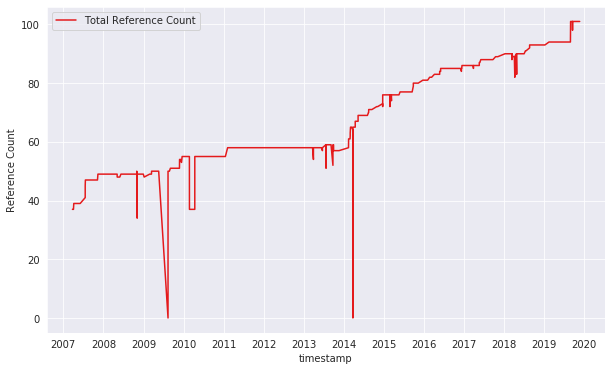

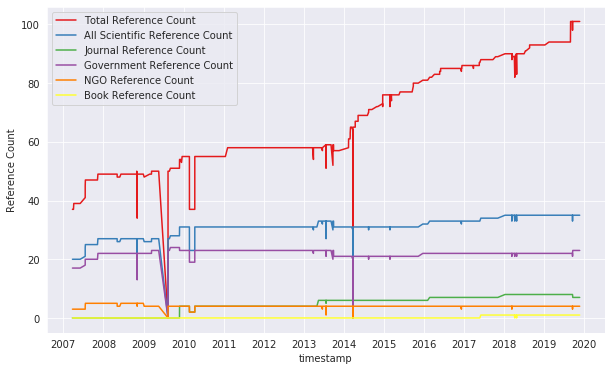

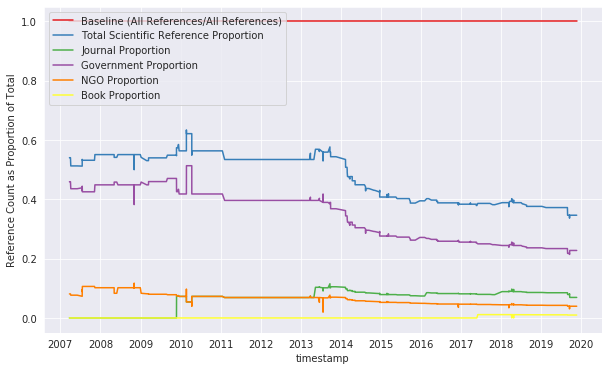

In [236]:
# Create the directory for figures
try:
    os.makedirs("../figs/")
except FileExistsError:
    pass
# Plot graphs


timeseries_plots(df=wikipedia_df_,
                 col_list=["all_references_count"],
                 legend_labels=["Total Reference Count"],
                 y_label="Reference Count",
                 save_name="figs/ref_total_count_"+fileout+".pdf")

timeseries_plots(df=wikipedia_df_,
                 col_list=["all_references_count","scientific_references_count","journal_references_count","government_references_count","ngo_references_count","book_references_count"],
                 legend_labels=["Total Reference Count","All Scientific Reference Count","Journal Reference Count","Government Reference Count","NGO Reference Count","Book Reference Count"],
                 y_label="Reference Count",
                 save_name="figs/ref_cat_count_"+fileout+".pdf")
    
timeseries_plots(df=wikipedia_df_,
                 col_list=["total_proportion","scientific_proportion","journal_proportion","government_proportion","ngo_proportion","book_proportion"],
                 legend_labels=["Baseline (All References/All References)","Total Scientific Reference Proportion","Journal Proportion","Government Proportion","NGO Proportion","Book Proportion"],
                 y_label="Reference Count as Proportion of Total",
                 save_name="figs/ref_cat_proportion_"+fileout+".pdf")

In [237]:
wikipedia_df_devandalized = wikipedia_df_.copy()

# Ignore likely vandalized pages (only keep revisions with greater than 5 total references)
wikipedia_df_devandalized = wikipedia_df_devandalized[(wikipedia_df_["all_references_count"] >= 5)]
wikipedia_df_devandalized = proportion_calculation(wikipedia_df_devandalized)

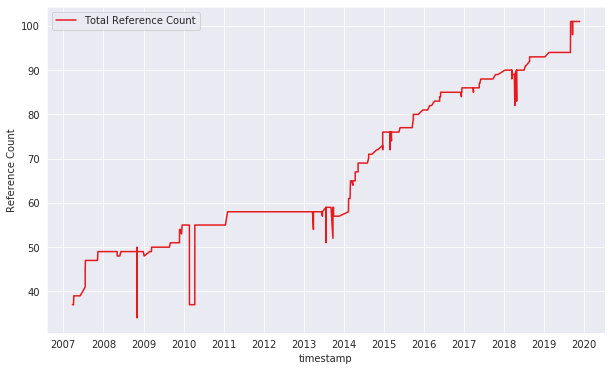

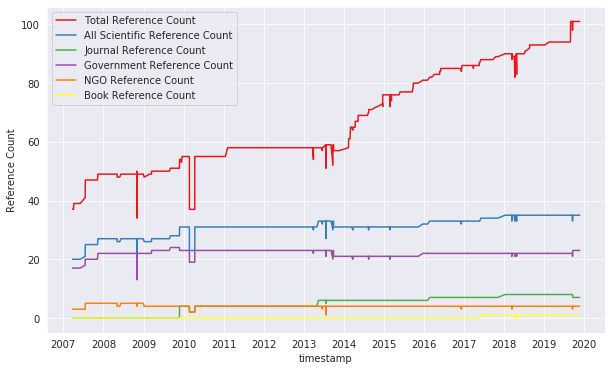

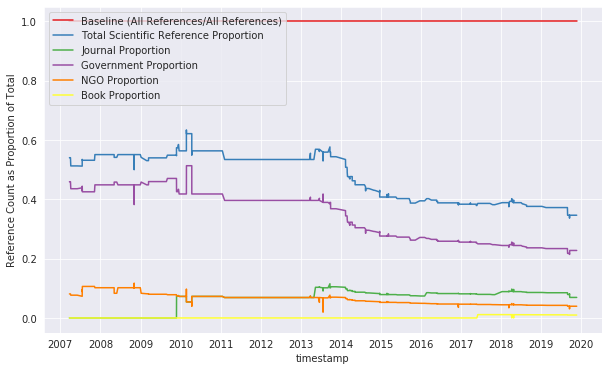

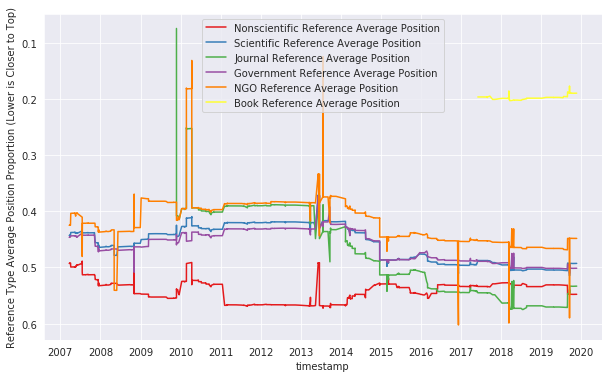

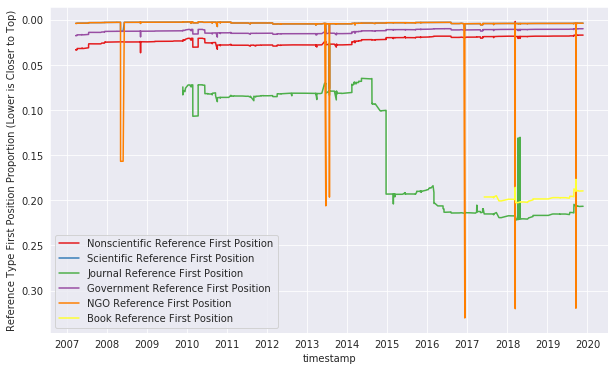

In [238]:
# As a proxy for the important of scientific references, find the position of the average of each reference type as well as the position of the first occurence of each type
# Because references appear and disappear over time, it would be difficult to keep track of specific references
def get_avg_first_ref_position(row):
    """
    Averages the positions of references according to type for each timestamp as proportion of total page character count.
    Also obtains the position of the first reference of each type.
    
    Parameters
    ----------
    row : pd.Series
        A pandas series

    Returns
    -------
    row : pd.Series
        A pandas series
    """
    
    col_from_list = ["journal_references","government_references","ngo_references","book_references","scientific_references","nonscientific_references"]
    col_avg_list = ["journal_references_average_pos","government_references_average_pos","ngo_references_average_pos","book_references_average_pos","scientific_references_average_pos","nonscientific_references_average_pos"]
    col_first_list = ["journal_references_first_pos","government_references_first_pos","ngo_references_first_pos","book_references_first_pos","scientific_references_first_pos","nonscientific_references_first_pos"]
    for i,j,k in zip(col_from_list,col_avg_list,col_first_list):
        try:
            row[j] = statistics.mean(list(row[i].values()))/row["total_character_count"]
            row[k] = min(list(row[i].values()))/row["total_character_count"]
        except:
            row[j] = np.nan
            row[k] = np.nan
    
    return row


wikipedia_df_devandalized = wikipedia_df_devandalized.apply(get_avg_first_ref_position, axis=1)

# Replot graphs
timeseries_plots(df=wikipedia_df_devandalized,
                     col_list=["all_references_count"],
                     legend_labels=["Total Reference Count"],
                     y_label="Reference Count",
                     save_name="figs/ref_devandalized_total_count_"+fileout+".pdf")

timeseries_plots(df=wikipedia_df_devandalized,
                     col_list=["all_references_count","scientific_references_count","journal_references_count","government_references_count","ngo_references_count","book_references_count"],
                     legend_labels=["Total Reference Count","All Scientific Reference Count","Journal Reference Count","Government Reference Count","NGO Reference Count","Book Reference Count"],
                     y_label="Reference Count",
                     save_name="figs/ref_devandalized_cat_count_"+fileout+".pdf")
    
timeseries_plots(df=wikipedia_df_devandalized,
                     col_list=["total_proportion","scientific_proportion","journal_proportion","government_proportion","ngo_proportion","book_proportion"],
                     legend_labels=["Baseline (All References/All References)","Total Scientific Reference Proportion","Journal Proportion","Government Proportion","NGO Proportion","Book Proportion"],
                     y_label="Reference Count as Proportion of Total",
                     save_name="figs/ref_devandalized_cat_proportion_"+fileout+".pdf")

# Plot the positions timeseries graphs
timeseries_plots(df=wikipedia_df_devandalized,
                    col_list=["nonscientific_references_average_pos","scientific_references_average_pos","journal_references_average_pos","government_references_average_pos","ngo_references_average_pos","book_references_average_pos"],
                    legend_labels=["Nonscientific Reference Average Position","Scientific Reference Average Position","Journal Reference Average Position","Government Reference Average Position","NGO Reference Average Position","Book Reference Average Position"],
                    invert_yaxis=True,
                    y_label="Reference Type Average Position Proportion (Lower is Closer to Top)",
                    save_name="figs/ref_devandalized_avg_position_"+fileout+".pdf")
    
timeseries_plots(df=wikipedia_df_devandalized,
                    col_list=["nonscientific_references_first_pos","scientific_references_first_pos","journal_references_first_pos","government_references_first_pos","ngo_references_first_pos","book_references_first_pos"],
                    legend_labels=["Nonscientific Reference First Position","Scientific Reference First Position","Journal Reference First Position","Government Reference First Position","NGO Reference First Position","Book Reference First Position"],
                    invert_yaxis=True,
                    y_label="Reference Type First Position Proportion (Lower is Closer to Top)",
                    save_name="figs/ref_devandalized_first_position_"+fileout+".pdf")

,timestamp,all_references_count,scientific_references_count,journal_references_count,government_references_count,ngo_references_count,book_references_count,total_character_count,nonscientific_references_average_pos,scientific_references_average_pos,journal_references_average_pos,government_references_average_pos,ngo_references_average_pos,book_references_average_pos,nonscientific_references_first_pos,scientific_references_first_pos,journal_references_first_pos,government_references_first_pos,ngo_references_first_pos,book_references_first_pos,climate_change_first_position,climate_change_average_position,climate_change_frequency,total_proportion,scientific_proportion,journal_proportion,government_proportion,ngo_proportion,book_proportion
119,2019-07-01 00:00:00+00:00,94.000,35.00,8.000,22.0,4.000,1.0,68007.500000,0.531277,0.504894,0.570754,0.501845,0.467032,0.196529,0.017793,0.003867,0.214542,0.010308,0.003867,0.196529,0.031189,0.414678,10.0,1.0,0.372340,0.085106,0.234043,0.042553,0.010638
120,2019-08-01 00:00:00+00:00,95.750,35.00,8.000,22.0,4.000,1.0,69149.500000,0.535760,0.502110,0.564919,0.500343,0.463325,0.193669,0.017625,0.003925,0.211390,0.010262,0.003925,0.193669,0.030804,0.410242,10.0,1.0,0.365535,0.083551,0.229765,0.041775,0.010444
121,2019-09-01 00:00:00+00:00,100.625,34.75,7.875,22.0,3.875,1.0,71726.750000,0.547795,0.495374,0.543968,0.497665,0.465717,0.187743,0.016711,0.003670,0.204831,0.009010,0.043147,0.187743,0.027638,0.395277,10.0,1.0,0.345342,0.078261,0.218634,0.038509,0.009938
122,2019-10-01 00:00:00+00:00,101.000,35.00,7.000,23.0,4.000,1.0,71985.666667,0.547723,0.492710,0.533288,0.501317,0.448039,0.189394,0.016929,0.003718,0.206467,0.009858,0.003718,0.189394,0.029585,0.396548,10.0,1.0,0.346535,0.069307,0.227723,0.039604,0.009901
123,2019-11-01 00:00:00+00:00,101.000,35.00,7.000,23.0,4.000,1.0,72094.000000,0.547722,0.492712,0.533207,0.501311,0.448203,0.189516,0.016839,0.003648,0.206564,0.009779,0.003648,0.189516,0.029475,0.396374,10.0,1.0,0.346535,0.069307,0.227723,0.039604,0.009901


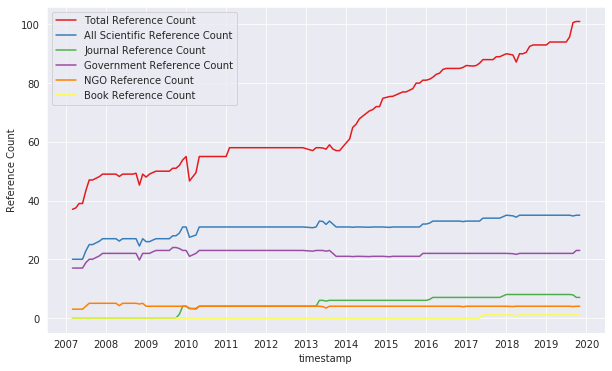

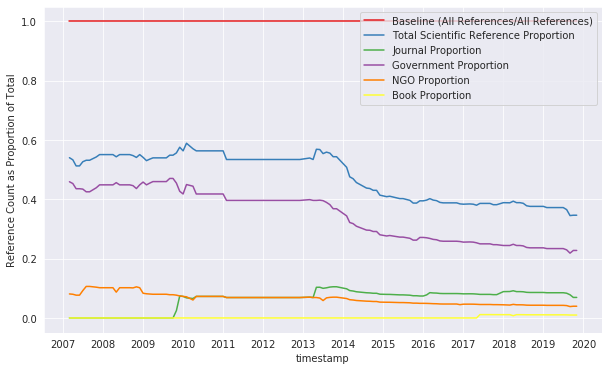

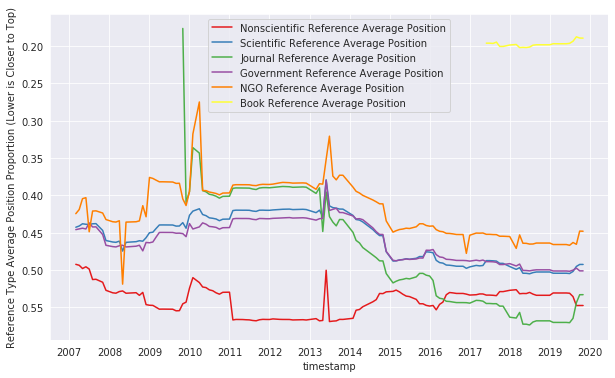

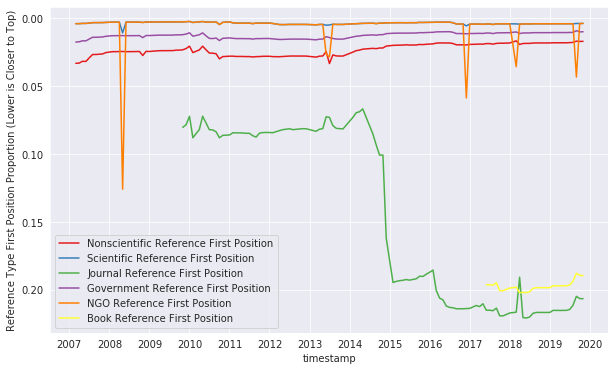

In [245]:
# Group by months and average relevant columns
cols_month = ["all_references_count","scientific_references_count","journal_references_count","government_references_count","ngo_references_count",
                "book_references_count","total_character_count","nonscientific_references_average_pos","scientific_references_average_pos","journal_references_average_pos",
                "government_references_average_pos","ngo_references_average_pos","book_references_average_pos","nonscientific_references_first_pos","scientific_references_first_pos",
                "journal_references_first_pos","government_references_first_pos","ngo_references_first_pos","book_references_first_pos",string_to_find.replace(" ","_")+"_first_position",
                string_to_find.replace(" ","_")+"_average_position",string_to_find.replace(" ","_")+"_frequency"]
wikipedia_df_month = wikipedia_df_devandalized.groupby(wikipedia_df_devandalized["timestamp"].dt.strftime("%Y-%m"))[cols_month].mean().reset_index()
wikipedia_df_month = proportion_calculation(wikipedia_df_month)
wikipedia_df_month["timestamp"] =  pd.to_datetime(wikipedia_df_month["timestamp"], utc=True)
display(wikipedia_df_month.tail())

# Replot graphs
timeseries_plots(df=wikipedia_df_month,
                     col_list=["all_references_count","scientific_references_count","journal_references_count","government_references_count","ngo_references_count","book_references_count"],
                     legend_labels=["Total Reference Count","All Scientific Reference Count","Journal Reference Count","Government Reference Count","NGO Reference Count","Book Reference Count"],
                     y_label="Reference Count",
                     save_name="figs/ref_month_cat_count_"+fileout+".pdf")
    
timeseries_plots(df=wikipedia_df_month,
                     col_list=["total_proportion","scientific_proportion","journal_proportion","government_proportion","ngo_proportion","book_proportion"],
                     legend_labels=["Baseline (All References/All References)","Total Scientific Reference Proportion","Journal Proportion","Government Proportion","NGO Proportion","Book Proportion"],
                     y_label="Reference Count as Proportion of Total",
                     save_name="figs/ref_month_cat_proportion_"+fileout+".pdf")

# Plot the positions timeseries graphs
timeseries_plots(df=wikipedia_df_month,
                    col_list=["nonscientific_references_average_pos","scientific_references_average_pos","journal_references_average_pos","government_references_average_pos","ngo_references_average_pos","book_references_average_pos"],
                    legend_labels=["Nonscientific Reference Average Position","Scientific Reference Average Position","Journal Reference Average Position","Government Reference Average Position","NGO Reference Average Position","Book Reference Average Position"],
                    invert_yaxis=True,
                    y_label="Reference Type Average Position Proportion (Lower is Closer to Top)",
                    save_name="figs/ref_month_avg_position_"+fileout+".pdf")
    
timeseries_plots(df=wikipedia_df_month,
                     col_list=["nonscientific_references_first_pos","scientific_references_first_pos","journal_references_first_pos","government_references_first_pos","ngo_references_first_pos","book_references_first_pos"],
                     legend_labels=["Nonscientific Reference First Position","Scientific Reference First Position","Journal Reference First Position","Government Reference First Position","NGO Reference First Position","Book Reference First Position"],
                     invert_yaxis=True,
                     y_label="Reference Type First Position Proportion (Lower is Closer to Top)",
                     save_name="figs/ref_month_first_position_"+fileout+".pdf")

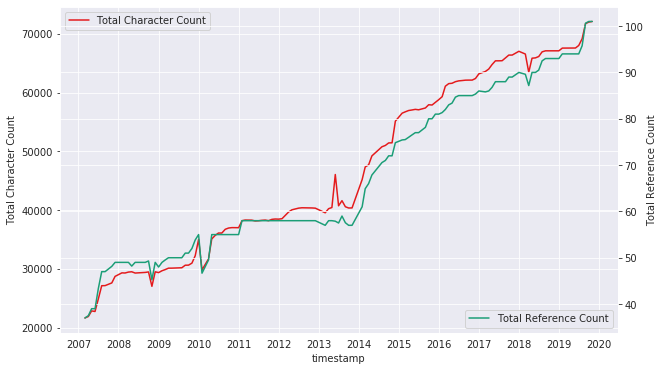

In [240]:
# Sanity check, make sure character count is roughly correlated with reference count
timeseries_plots(df=wikipedia_df_month,
                    col_list=["total_character_count"],
                    legend_labels=["Total Character Count"],
                    y_label="Total Character Count",
                    multiaxis=True,
                    col2_list=["all_references_count"],
                    legend2_labels=["Total Reference Count"],
                    y2_label="Total Reference Count",
                    save_name="figs/ref_char_count_comparison_"+fileout+".pdf") 

## Scopus Search API Data Download and Analysis with Respect to Wikipedia

To see if Wikipedia is updated in a way that could be correlated with the accumulation of scientific knowledge over time, use Scopus Search API to search for published articles with the terms "great barrier reef" and "climate change" in title/abstract/keywords

In [241]:
# Use the pybliometrics API wrapper to utilize the Scopus Search API. 

# api_key = "b735ea3a9a87e79de55360dbdf701b5d"

# # Setup pybliometrics configuration file for API key
# try:
#     pybliometrics.scopus.utils.create_config()
# except:
#     pass

In [242]:
# Do a Scopus Search on Great Barrier Reef and climate change
query = 'TITLE-ABS-KEY("great barrier reef" AND "climate change")'

search = ScopusSearch(query,verbose=True,subscriber=False)
print(search.results[:5])

pd.set_option("display.max_columns", 500)

scopus_df = pd.DataFrame(search.results)
scopus_df.to_csv("scopus_gbr_cc_search_results.csv")
display(scopus_df)

[Document(eid='2-s2.0-85073953047', doi='10.1007/s00338-019-01857-x', pii=None, pubmed_id=None, title='Evolution, diversity, distribution and the endangered future of the giant clam–Symbiodiniaceae association', subtype='re', creator='Mies M.', afid=None, affilname='Universidade de Sao Paulo - USP', affiliation_city=None, affiliation_country=None, author_count=None, author_names=None, author_ids=None, author_afids=None, coverDate='2019-12-01', coverDisplayDate='1 December 2019', publicationName='Coral Reefs', issn='07224028', source_id='26825', eIssn='14320975', aggregationType='Journal', volume='38', issueIdentifier='6', article_number=None, pageRange='1067-1084', description=None, authkeywords=None, citedby_count='0', openaccess='0', fund_acr=None, fund_no=None, fund_sponsor=None), Document(eid='2-s2.0-85071401379', doi='10.1016/j.epsl.2019.115785', pii='S0012821X19304777', pubmed_id=None, title='Deconvolving the long-term impacts of ocean acidification and warming on coral biominera

,eid,doi,pii,pubmed_id,title,subtype,creator,afid,affilname,affiliation_city,affiliation_country,author_count,author_names,author_ids,author_afids,coverDate,coverDisplayDate,publicationName,issn,source_id,eIssn,aggregationType,volume,issueIdentifier,article_number,pageRange,description,authkeywords,citedby_count,openaccess,fund_acr,fund_no,fund_sponsor
0,2-s2.0-85073953047,10.1007/s00338-019-01857-x,None,None,"Evolution, diversity, distribution and the end...",re,Mies M.,None,Universidade de Sao Paulo - USP,None,None,None,None,None,None,2019-12-01,1 December 2019,Coral Reefs,07224028,26825,14320975,Journal,38,6,None,1067-1084,None,None,0,0,None,None,None
1,2-s2.0-85071401379,10.1016/j.epsl.2019.115785,S0012821X19304777,None,Deconvolving the long-term impacts of ocean ac...,ar,D'Olivo J.,None,University of Western Australia;ARC Centre of ...,None,None,None,None,None,None,2019-11-15,15 November 2019,Earth and Planetary Science Letters,0012821X,22566,None,Journal,526,None,115785,None,None,None,0,1,None,None,None
2,2-s2.0-85073811214,10.1002/ieam.4180,None,31273905,Towards Sustainable Environmental Quality: Pri...,ar,Gaw S.,None,University of Canterbury,None,None,None,None,None,None,2019-11-01,1 November 2019,Integrated Environmental Assessment and Manage...,15513793,4400151417,None,Journal,15,6,None,917-935,None,None,0,1,None,None,None
3,2-s2.0-85067466098,10.1016/j.envsci.2019.04.016,S1462901118313819,None,Regulatory implications of coral reef restorat...,ar,Fidelman P.,None,University of Queensland;Centre for Marine Soc...,None,None,None,None,None,None,2019-10-01,October 2019,Environmental Science and Policy,14629011,21536,18736416,Journal,100,None,None,221-229,None,None,0,0,None,None,None
4,2-s2.0-85071483043,10.1002/ece3.5616,None,None,The active spread of adaptive variation for re...,ar,Quigley K.,None,Australian Institute of Marine Science,None,None,None,None,None,None,2019-10-01,1 October 2019,Ecology and Evolution,None,21100264002,20457758,Journal,9,19,None,11122-11135,None,None,0,1,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,2-s2.0-0030729593,10.1029/97PA00318,None,None,Strontium/calcium ratios in modern porites cor...,ar,Alibert C.,None,Australian National University,None,None,None,None,None,None,1997-06-01,1 June 1997,Paleoceanography,08838305,22278,19449186,Journal,12,3,None,345-363,None,None,216,0,None,None,None
377,2-s2.0-0030429932,10.1130/0091-7613(1996)024<1009:TCBCHU>2.3.CO;2,None,None,Timing coral-based climatic histories using <s...,ar,Gagan M.,None,Australian National University,None,None,None,None,None,None,1996-01-01,November 1996,Geology,00917613,26959,None,Journal,24,11,None,1009-1012,None,None,40,0,None,None,None
378,2-s2.0-0027796611,None,None,None,"High-resolution sequence stratigraphy, condens...",ar,Glenn C.,None,None,None,None,None,None,None,None,1993-01-01,1993,"Proc., scientific results, ODP, Leg 133, north...",None,21100684033,None,Book,None,None,None,353-364,None,None,9,0,None,None,None
379,2-s2.0-0027832656,None,None,None,Controls on the Pliocene-Pleistocene evolution...,ar,Davies P.,None,None,None,None,None,None,None,None,1993-01-01,1993,"Proc., scientific results, ODP, Leg 133, north...",None,21100684033,None,Book,None,None,None,755-762,None,None,20,0,None,None,None


In [243]:
# I am only interested in the dates of publishing
scopus_df_ = scopus_df.copy()
scopus_df_ = scopus_df_[["coverDate","doi"]]
print(type(scopus_df_.loc[0,"coverDate"]))

# Convert string dates to tz aware datetime objects
scopus_df_["timestamp"] =  pd.to_datetime(scopus_df_["coverDate"], utc=True)#, format='%Y-%M-%d:%H:%M:%S.%f')
print(type(scopus_df_.loc[0,"timestamp"]))
display(scopus_df_)

# Aggregate publication count per month
scopus_df_["publication_count"] = 1
# display(scopus_df_)
scopus_df_ = scopus_df_[["timestamp","publication_count"]]
scopus_df_month = scopus_df_.groupby(scopus_df_["timestamp"].dt.strftime("%Y-%m"))["publication_count"].sum().reset_index()
scopus_df_month["publication_count"] = scopus_df_month["publication_count"].cumsum()
scopus_df_month["timestamp"] =  pd.to_datetime(scopus_df_month["timestamp"], utc=True)
display(scopus_df_month)

wikipedia_scopus_df = pd.merge(wikipedia_df_month,scopus_df_month,how="inner",on="timestamp")
display(wikipedia_scopus_df)

<class 'str'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,coverDate,doi,timestamp
0,2019-12-01,10.1007/s00338-019-01857-x,2019-12-01 00:00:00+00:00
1,2019-11-15,10.1016/j.epsl.2019.115785,2019-11-15 00:00:00+00:00
2,2019-11-01,10.1002/ieam.4180,2019-11-01 00:00:00+00:00
3,2019-10-01,10.1016/j.envsci.2019.04.016,2019-10-01 00:00:00+00:00
4,2019-10-01,10.1002/ece3.5616,2019-10-01 00:00:00+00:00
...,...,...,...
376,1997-06-01,10.1029/97PA00318,1997-06-01 00:00:00+00:00
377,1996-01-01,10.1130/0091-7613(1996)024<1009:TCBCHU>2.3.CO;2,1996-01-01 00:00:00+00:00
378,1993-01-01,None,1993-01-01 00:00:00+00:00
379,1993-01-01,None,1993-01-01 00:00:00+00:00


,timestamp,publication_count
0,1993-01-01 00:00:00+00:00,3
1,1996-01-01 00:00:00+00:00,4
2,1997-06-01 00:00:00+00:00,5
3,1997-11-01 00:00:00+00:00,6
4,2000-01-01 00:00:00+00:00,9
...,...,...
146,2019-08-01 00:00:00+00:00,373
147,2019-09-01 00:00:00+00:00,376
148,2019-10-01 00:00:00+00:00,378
149,2019-11-01 00:00:00+00:00,380


,timestamp,all_references_count,scientific_references_count,journal_references_count,government_references_count,ngo_references_count,book_references_count,total_character_count,nonscientific_references_average_pos,scientific_references_average_pos,journal_references_average_pos,government_references_average_pos,ngo_references_average_pos,book_references_average_pos,nonscientific_references_first_pos,scientific_references_first_pos,journal_references_first_pos,government_references_first_pos,ngo_references_first_pos,book_references_first_pos,climate_change_first_position,climate_change_average_position,climate_change_frequency,total_proportion,scientific_proportion,journal_proportion,government_proportion,ngo_proportion,book_proportion,publication_count
0,2007-05-01 00:00:00+00:00,39.000000,20.000000,0.000,17.000000,3.000,0.0,22862.181818,0.498169,0.438224,NaN,0.444159,0.404597,NaN,0.031538,0.003631,NaN,0.016447,0.003631,NaN,0.061502,0.177411,2.0,1.0,0.512821,0.000000,0.435897,0.076923,0.000000,35
1,2007-06-01 00:00:00+00:00,39.000000,20.000000,0.000,17.000000,3.000,0.0,22762.666667,0.495854,0.438894,NaN,0.445182,0.403263,NaN,0.031675,0.003646,NaN,0.016518,0.003646,NaN,0.061768,0.177857,2.0,1.0,0.512821,0.000000,0.435897,0.076923,0.000000,36
2,2007-08-01 00:00:00+00:00,47.000000,25.000000,0.000,20.000000,5.000,0.0,27146.000000,0.512925,0.438252,NaN,0.442520,0.421182,NaN,0.026560,0.003058,NaN,0.013851,0.003058,NaN,0.051794,0.338343,3.0,1.0,0.531915,0.000000,0.425532,0.106383,0.000000,37
3,2007-11-01 00:00:00+00:00,48.142857,26.142857,0.000,21.142857,5.000,0.0,27620.714286,0.516585,0.447161,NaN,0.452634,0.423812,NaN,0.026111,0.003006,NaN,0.013617,0.003006,NaN,0.050728,0.341826,3.0,1.0,0.543027,0.000000,0.439169,0.103858,0.000000,38
4,2007-12-01 00:00:00+00:00,49.000000,27.000000,0.000,22.000000,5.000,0.0,28735.400000,0.527369,0.460674,NaN,0.467067,0.432547,NaN,0.025101,0.002890,NaN,0.013090,0.002890,NaN,0.048949,0.352426,3.0,1.0,0.551020,0.000000,0.448980,0.102041,0.000000,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,2019-07-01 00:00:00+00:00,94.000000,35.000000,8.000,22.000000,4.000,1.0,68007.500000,0.531277,0.504894,0.570754,0.501845,0.467032,0.196529,0.017793,0.003867,0.214542,0.010308,0.003867,0.196529,0.031189,0.414678,10.0,1.0,0.372340,0.085106,0.234043,0.042553,0.010638,368
97,2019-08-01 00:00:00+00:00,95.750000,35.000000,8.000,22.000000,4.000,1.0,69149.500000,0.535760,0.502110,0.564919,0.500343,0.463325,0.193669,0.017625,0.003925,0.211390,0.010262,0.003925,0.193669,0.030804,0.410242,10.0,1.0,0.365535,0.083551,0.229765,0.041775,0.010444,373
98,2019-09-01 00:00:00+00:00,100.625000,34.750000,7.875,22.000000,3.875,1.0,71726.750000,0.547795,0.495374,0.543968,0.497665,0.465717,0.187743,0.016711,0.003670,0.204831,0.009010,0.043147,0.187743,0.027638,0.395277,10.0,1.0,0.345342,0.078261,0.218634,0.038509,0.009938,376
99,2019-10-01 00:00:00+00:00,101.000000,35.000000,7.000,23.000000,4.000,1.0,71985.666667,0.547723,0.492710,0.533288,0.501317,0.448039,0.189394,0.016929,0.003718,0.206467,0.009858,0.003718,0.189394,0.029585,0.396548,10.0,1.0,0.346535,0.069307,0.227723,0.039604,0.009901,378


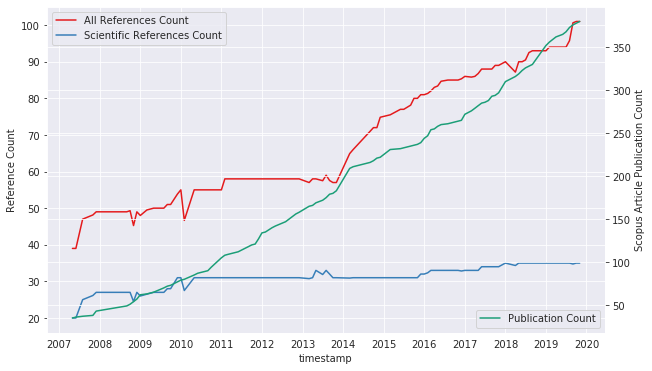

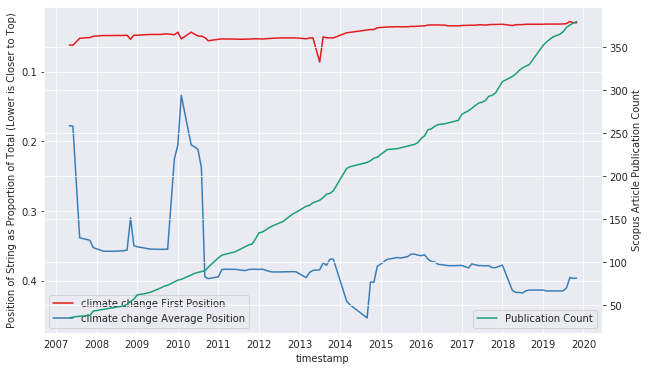

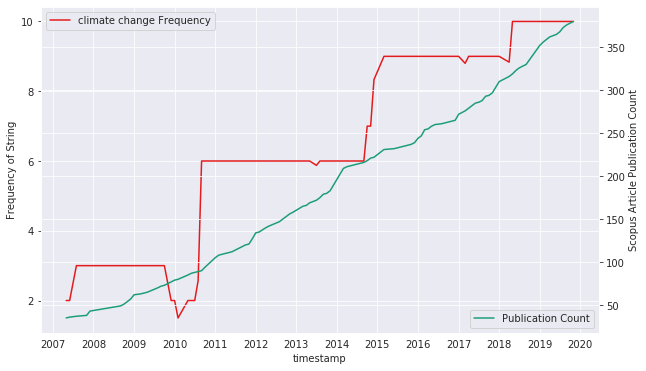

In [244]:
# Plot both dataframes to compare dates of publications and reference count
timeseries_plots(df=wikipedia_scopus_df,
                    col_list=["all_references_count","scientific_references_count"],
                    legend_labels=["All References Count","Scientific References Count"],
                    y_label="Reference Count",
                    multiaxis=True,
                    col2_list=["publication_count"],
                    legend2_labels=["Publication Count"],
                    y2_label="Scopus Article Publication Count",
                    save_name="figs/scopus_count_comparison_"+fileout+".pdf") 

# Plot both dataframes to compare dates of publications and frequency/position of the term "climate change"
timeseries_plots(df=wikipedia_scopus_df,
                    col_list=[string_to_find.replace(" ","_")+"_first_position",string_to_find.replace(" ","_")+"_average_position"],
                    legend_labels=[string_to_find+" First Position",string_to_find+" Average Position"],
                    y_label="Position of String as Proportion of Total (Lower is Closer to Top)",
                    invert_yaxis=True,
                    multiaxis=True,
                    col2_list=["publication_count"],
                    legend2_labels=["Publication Count"],
                    y2_label="Scopus Article Publication Count",
                    save_name="figs/scopus_string_position_comparison_"+fileout+".pdf")

timeseries_plots(df=wikipedia_scopus_df,
                    col_list=[string_to_find.replace(" ","_")+"_frequency"],
                    legend_labels=[string_to_find+" Frequency"],
                    y_label="Frequency of String",
                    multiaxis=True,
                    col2_list=["publication_count"],
                    legend2_labels=["Publication Count"],
                    y2_label="Scopus Article Publication Count",
                    save_name="figs/scopus_string_frequency_comparison_"+fileout+".pdf")